# Topic Modeling

In [1]:
import warnings
from typing import Tuple, Optional

import matplotlib.pyplot as plt
import numpy as np

from loader import IssueLoader
from models.lda_model import LDAModel, coherence_scores
from models.naive_model import NaiveModel
from tokenizer import Tokenizer

warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1123)>


In [2]:
loader = IssueLoader.from_json("data/pycharm_issues.json")
print(f"Количество отчетов: {len(loader)}")

Количество отчетов: 2370


In [3]:
versions = loader.get_versions()
print(f"Версии: {sorted(versions)}")

Версии: ['2020.2', '2020.3', '2021.1', '2021.2', '2021.3']


In [4]:
random_state = 42

## Решение 1: Наивное решение на основе частот

In [5]:
def print_results(method, loader): 
    for version in sorted(loader.get_versions()): 
        issues = loader.get_by_version(version)
        words = method([issue.summary for issue in issues])
        
        print(f"Версия: {version}")
        print(f"Самые встречаемые слова:")
        print(words)

Посторим простейшее решение, основываясь на встречаемости слов (будем использовать как просто **TF**, так и **TF-IDF**, посмотрим, что получится). Так как **description** содержит большое количество технической информации, с которой трудно работаь, то будем опираться только на **summary**. 
Сложность -- правильно предобработать текст для подсчета статистик. Для того, чтобы сохранить устойчивые выражния, фразы, написанные в ковычках, будут считаться как отдельный токен. 

Сначала попробуем "наивное" решение со стандартным токенайзером, количество слов -- 10. 

In [6]:
tokenizer = Tokenizer(ignore_quotes=True)
model = NaiveModel(10, tokenizer, max_freq=0.5)

Подход на основе **TF**. 

In [7]:
print_results(model.most_tf_words, loader)

Версия: 2020.2
Самые встречаемые слова:
['pycharm', 'python', 'type', 'console', 'interpreter', 'code', 'jupyter', 'project', 'file', 'debugger']
Версия: 2020.3
Самые встречаемые слова:
['pycharm', 'python', 'type', 'package', 'project', 'file', 'doesnt', 'interpreter', 'import', 'class']
Версия: 2021.1
Самые встречаемые слова:
['type', 'python', 'pycharm', 'code', 'file', 'project', 'doesnt', 'interpreter', 'error', 'work']
Версия: 2021.2
Самые встречаемые слова:
['python', 'type', 'pycharm', 'interpreter', 'code', 'error', 'project', 'file', 'console', 'false']
Версия: 2021.3
Самые встречаемые слова:
['python', 'type', 'pycharm', 'show', 'console', 'doesnt', 'run', 'error', 'work', 'new']


Мало что понятно, однако уже можно предположить, что изменения могут быть связаны с **"console"**, **"package"**, **"import"**.

Теперь по **TF-IDF**. 

In [8]:
print_results(model.most_tf_idf_words, loader)

Версия: 2020.2
Самые встречаемые слова:
['pycharm', 'python', 'type', 'console', 'interpreter', 'jupyter', 'code', 'project', 'file', 'debugger']
Версия: 2020.3
Самые встречаемые слова:
['pycharm', 'python', 'type', 'package', 'project', 'file', 'doesnt', 'interpreter', 'import', 'class']
Версия: 2021.1
Самые встречаемые слова:
['type', 'python', 'pycharm', 'code', 'file', 'project', 'interpreter', 'doesnt', 'package', 'error']
Версия: 2021.2
Самые встречаемые слова:
['python', 'type', 'pycharm', 'interpreter', 'code', 'error', 'project', 'file', 'false', 'console']
Версия: 2021.3
Самые встречаемые слова:
['python', 'type', 'pycharm', 'show', 'console', 'doesnt', 'run', 'error', 'function', 'work']


Здесь ситуация изменилась не сильно. 

Теперь попробуем сделать так, чтобы словосочетания в ковычках учитывал воспринимались как одно слово. 

In [9]:
tokenizer = Tokenizer(ignore_quotes=False)
model = NaiveModel(10, tokenizer, max_freq=0.5)

In [10]:
print_results(model.most_tf_words, loader)

Версия: 2020.2
Самые встречаемые слова:
['pycharm', 'python', 'type', 'console', 'code', 'interpreter', 'file', 'jupyter', 'project', 'doesnt']
Версия: 2020.3
Самые встречаемые слова:
['pycharm', 'python', 'type', 'project', 'doesnt', 'interpreter', 'package', 'file', 'class', 'code']
Версия: 2021.1
Самые встречаемые слова:
['type', 'python', 'pycharm', 'code', 'file', 'doesnt', 'interpreter', 'project', 'work', 'error']
Версия: 2021.2
Самые встречаемые слова:
['type', 'python', 'pycharm', 'interpreter', 'code', 'error', 'project', 'file', 'false', 'class']
Версия: 2021.3
Самые встречаемые слова:
['python', 'type', 'pycharm', 'doesnt', 'error', 'work', 'run', 'ui', 'interpreter', 'eap']


In [11]:
print_results(model.most_tf_idf_words, loader)

Версия: 2020.2
Самые встречаемые слова:
['pycharm', 'python', 'type', 'console', 'interpreter', 'code', 'file', 'jupyter', 'project', 'doesnt']
Версия: 2020.3
Самые встречаемые слова:
['pycharm', 'python', 'type', 'project', 'doesnt', 'interpreter', 'package', 'class', 'file', 'code']
Версия: 2021.1
Самые встречаемые слова:
['type', 'pycharm', 'python', 'code', 'file', 'interpreter', 'doesnt', 'project', 'work', 'error']
Версия: 2021.2
Самые встречаемые слова:
['type', 'python', 'pycharm', 'interpreter', 'code', 'error', 'project', 'file', 'false', 'class']
Версия: 2021.3
Самые встречаемые слова:
['python', 'type', 'pycharm', 'doesnt', 'error', 'function', 'work', 'run', 'ui', 'interpreter']


Такая токенизация не сильно помогла. 

Попробуем ещё токенизацию на основе 2-gram.

In [12]:
tokenizer = Tokenizer(n_gram=2)
model = NaiveModel(15, tokenizer)

In [13]:
print_results(model.most_tf_words, loader)

Версия: 2020.2
Самые встречаемые слова:
['python console', 'jupyter notebook', 'doesnt work', 'false positive', 'python interpreter', 'find usage', 'unresolved reference', 'pycharm 20202', 'notebook preview', 'expected type', 'return type', 'remote interpreter', 'false negative', '20202 eap', 'high cpu']
Версия: 2020.3
Самые встречаемые слова:
['false positive', 'python console', 'doesnt work', 'unresolved reference', 'type annotation', 'jupyter notebook', 'pycharm 20203', 'python interpreter', 'python 39', 'code completion', 'error running', 'dunder init', 'nonnative namespace', 'wrong type', 'remote interpreter']
Версия: 2021.1
Самые встречаемые слова:
['doesnt work', 'false positive', 'python interpreter', 'python console', 'code completion', 'pycharm doesnt', 'tool window', 'type inference', 'type checking', 'run configuration', 'python file', 'false negative', 'debug console', 'docker compose', 'type hint']
Версия: 2021.2
Самые встречаемые слова:
['python console', 'false positive

В **2020.2** есть "find usage", "notebook preview" , "expected type", "return type", "high cpu".  
В **2020.3** есть "type annotation", "python 3.9", "code completion", "dunder init", "wrong type", "non-native namespace".  
Интересные наблюдения, возможно, помогут в будущем. 

**Вывод по частотному подходу:** всегда будут появляться самые популярные слова, которые почти не несут смысловой нагрузки. Поэтому данных подход не самый подходящий. 

## Решение 2: На основе LDA 

К сожалению, **BigArtm** поставить на Mac не получилось, поэтому буду пробывать с помощью **LDA**. 

In [14]:
tokenizer = Tokenizer(ignore_quotes=True)
n_components = list(range(1, 300))
summaries = [issue.summary for issue in loader.issues]
scores = coherence_scores(tokenizer, summaries, n_components, random_state)

100%|██████████| 299/299 [04:43<00:00,  1.06it/s]


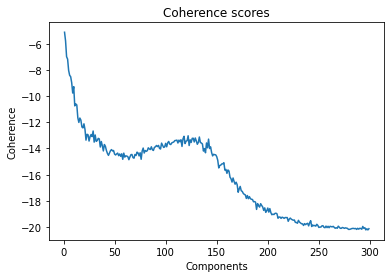

In [15]:
plt.plot(n_components, scores)
plt.title("Coherence scores")
plt.xlabel("Components")
plt.ylabel("Coherence")
plt.show()

Таким образом, возьмем количество компонент, равным **31** (маленький пик на графике). 

In [16]:
lda = LDAModel(31, tokenizer, random_state).fit(summaries)
topics = lda.get_topics(summaries)

versions = np.array([issue.version for issue in loader.issues])
topics = np.array(topics)

Теперь посмотрим на распределение тем по каждой версии. 

In [17]:
def top_topics_distributions(topics: np.ndarray, top_n: Optional[int] = None) -> Tuple[np.ndarray, np.ndarray]: 
    n_issues = len(topics)
    unique_topics, counts = np.unique(topics, return_counts=True)
    sorted_idx = np.argsort(-counts)
    
    unique_topics_top = unique_topics[sorted_idx][:top_n]
    counts_top = counts[sorted_idx][:top_n]
    
    return unique_topics_top, counts_top

In [18]:
top_topics = {version: top_topics_distributions(topics[versions == version])
              for version in loader.get_versions()}

Посмотрим на распределение по тематикам для каждого документа. 

In [19]:
for version in sorted(loader.get_versions()): 
    print(f"Версия: {version}")
    print("Распределения по тематикам:")
    print(top_topics[version][1])

Версия: 2020.2
Распределения по тематикам:
[29 28 27 27 27 25 25 23 23 23 23 22 21 21 21 20 19 19 18 18 18 18 18 17
 16 14 14 14 13 12 12]
Версия: 2020.3
Распределения по тематикам:
[27 25 24 23 23 22 21 20 20 19 19 18 18 18 18 16 16 15 14 14 14 14 14 14
 13 13 13 11 10  8  8]
Версия: 2021.1
Распределения по тематикам:
[34 31 31 29 26 26 26 25 22 22 21 21 20 20 20 20 19 18 16 16 16 15 15 14
 14 13 13 13 10  9  7]
Версия: 2021.2
Распределения по тематикам:
[34 29 26 25 24 24 22 22 22 20 20 20 19 18 18 17 16 16 16 15 12 12 12 12
 11 11 11 11  9  8  7]
Версия: 2021.3
Распределения по тематикам:
[7 6 6 5 5 4 4 4 4 3 3 3 3 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1]


Как можно видеть, распределение тематик меняется постепенно, поэтому трудно аналазировать такие данные. 

Посмотрим на все получившиеся темы. 

In [20]:
lda.visualize(summaries)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
17    -0.101102 -0.094393       1        1  4.514460
3     -0.101037  0.034773       2        1  4.122075
11     0.149206 -0.063756       3        1  4.072050
7     -0.019732  0.013467       4        1  3.990181
13     0.047864 -0.079827       5        1  3.955008
21    -0.119268 -0.014616       6        1  3.834065
27    -0.071162  0.020939       7        1  3.826610
5      0.007608  0.057455       8        1  3.793619
26     0.145025  0.059537       9        1  3.791012
18     0.083664  0.022425      10        1  3.762259
20    -0.001671 -0.056545      11        1  3.567086
6      0.074379 -0.006568      12        1  3.544672
14     0.135975  0.034782      13        1  3.317060
0      0.031936 -0.061452      14        1  3.225499
9      0.000474 -0.029735      15        1  3.197102
4     -0.085233  0.066396      16        1  3.143775
16     0.043244 -0.048047      17        1  3.125202
30    -0.035475 -0.069040      18        1  2.951308
28    -0.034396 -0.069493      19        1  2.944523
24    -0.161279 -0.024669      20        1  2.932543
1      0.013052 -0.002809      21        1  2.879233
12    -0.049841  0.185950      22        1  2.867078
29    -0.031263 -0.061722      23        1  2.851335
25     0.040347 -0.058874      24        1  2.844618
10    -0.012048 -0.007371      25        1  2.657975
23     0.019507 -0.052292      26        1  2.632975
2     -0.045085  0.093295      27        1  2.606154
15    -0.021716  0.122891      28        1  2.427823
19     0.035290  0.018954      29        1  2.247140
22     0.099650  0.090894      30        1  2.229598
8     -0.036912 -0.020550      31        1  2.145963, topic_info=            Term        Freq       Total Category  logprob  loglift
368  interpreter  173.000000  173.000000  Default  30.0000  30.0000
476     debugger   89.000000   89.000000  Default  29.0000  29.0000
79          type  297.000000  297.000000  Default  28.0000  28.0000
63        python  331.000000  331.000000  Default  27.0000  27.0000
187          run  111.000000  111.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
249      setting    4.010272   62.656913  Topic31  -4.4599   1.0928
128       module    4.336609   97.585851  Topic31  -4.3817   0.7279
31       pycharm    6.498615  256.687989  Topic31  -3.9772   0.1653
63        python    5.168089  331.150641  Topic31  -4.2063  -0.3185
79          type    4.072643  297.736000  Topic31  -4.4445  -0.4503

[1552 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1355      5  0.468841     10
1355     21  0.375073     10
2723     17  0.766423     11
583       4  0.068060      2
583      12  0.068060      2
...     ...       ...    ...
245      26  0.080235      x
245      31  0.401173      x
2517      9  0.919076    xml
1977     15  0.870250   yaml
136      24  0.698383  yield

[2999 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 4, 12, 8, 14, 22, 28, 6, 27, 19, 21, 7, 15, 1, 10, 5, 17, 31, 29, 25, 2, 13, 30, 26, 11, 24, 3, 16, 20, 23, 9])

Теперь посмотрм на темы из релиза "2020.2" и "2020.3". 

In [21]:
lda.visualize(np.array(summaries)[versions == "2020.2"])

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
27    -0.071162  0.020939       1        1  4.589587
11     0.149206 -0.063756       2        1  4.431125
17    -0.101102 -0.094393       3        1  4.077252
5      0.007608  0.057455       4        1  3.984533
16     0.043244 -0.048047       5        1  3.982396
13     0.047864 -0.079827       6        1  3.922726
7     -0.019732  0.013467       7        1  3.812443
3     -0.101037  0.034773       8        1  3.636525
25     0.040347 -0.058874       9        1  3.523060
0      0.031936 -0.061452      10        1  3.423073
18     0.083664  0.022425      11        1  3.384661
9      0.000474 -0.029735      12        1  3.335715
4     -0.085233  0.066396      13        1  3.296683
30    -0.035475 -0.069040      14        1  3.145689
24    -0.161279 -0.024669      15        1  3.067966
21    -0.119268 -0.014616      16        1  3.064080
6      0.074379 -0.006568      17        1  3.043122
26     0.145025  0.059537      18        1  3.036854
29    -0.031263 -0.061722      19        1  2.988465
12    -0.049841  0.185950      20        1  2.982611
14     0.135975  0.034782      21        1  2.941133
28    -0.034396 -0.069493      22        1  2.926107
20    -0.001671 -0.056545      23        1  2.888127
1      0.013052 -0.002809      24        1  2.838683
10    -0.012048 -0.007371      25        1  2.798625
2     -0.045085  0.093295      26        1  2.706820
19     0.035290  0.018954      27        1  2.580107
8     -0.036912 -0.020550      28        1  2.495127
22     0.099650  0.090894      29        1  2.456214
15    -0.021716  0.122891      30        1  2.454365
23     0.019507 -0.052292      31        1  2.186128, topic_info=             Term       Freq      Total Category  logprob  loglift
79           type  73.000000  73.000000  Default  30.0000  30.0000
368   interpreter  44.000000  44.000000  Default  29.0000  29.0000
476      debugger  22.000000  22.000000  Default  28.0000  28.0000
63         python  86.000000  86.000000  Default  27.0000  27.0000
187           run  28.000000  28.000000  Default  26.0000  26.0000
...           ...        ...        ...      ...      ...      ...
357           wsl   1.019156  13.983845  Topic31  -4.5008   1.2041
1135         save   0.466140   3.453487  Topic31  -5.2831   1.8204
14           file   1.501732  36.180080  Topic31  -4.1132   0.6411
83      attribute   0.840896  11.692983  Topic31  -4.6931   1.1908
31        pycharm   1.539219  67.098649  Topic31  -4.0885   0.0481

[1561 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1355      6  0.360454     10
1355     24  0.360454     10
2723      5  0.600573     11
583      21  0.267970      2
583      26  0.267970      2
...     ...       ...    ...
245       1  0.272909      x
245      28  0.272909      x
2517     18  0.846278    xml
1977     12  0.645397   yaml
136       9  0.572067  yield

[1723 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[28, 12, 18, 6, 17, 14, 8, 4, 26, 1, 19, 10, 5, 31, 25, 22, 7, 27, 30, 13, 15, 29, 21, 2, 11, 3, 20, 9, 23, 16, 24])

In [22]:
lda.visualize(np.array(summaries)[versions == "2020.3"])

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
21    -0.119268 -0.014616       1        1  5.069898
26     0.145025  0.059537       2        1  4.306859
5      0.007608  0.057455       3        1  4.292552
11     0.149206 -0.063756       4        1  4.016672
4     -0.085233  0.066396       5        1  3.862022
13     0.047864 -0.079827       6        1  3.853502
7     -0.019732  0.013467       7        1  3.849852
3     -0.101037  0.034773       8        1  3.824556
18     0.083664  0.022425       9        1  3.766236
17    -0.101102 -0.094393      10        1  3.690432
14     0.135975  0.034782      11        1  3.650198
6      0.074379 -0.006568      12        1  3.358499
28    -0.034396 -0.069493      13        1  3.344965
20    -0.001671 -0.056545      14        1  3.294943
2     -0.045085  0.093295      15        1  3.133888
0      0.031936 -0.061452      16        1  3.012034
29    -0.031263 -0.061722      17        1  3.009656
27    -0.071162  0.020939      18        1  3.005141
30    -0.035475 -0.069040      19        1  2.997572
9      0.000474 -0.029735      20        1  2.949955
8     -0.036912 -0.020550      21        1  2.916380
24    -0.161279 -0.024669      22        1  2.903383
23     0.019507 -0.052292      23        1  2.867950
25     0.040347 -0.058874      24        1  2.827675
1      0.013052 -0.002809      25        1  2.808463
16     0.043244 -0.048047      26        1  2.775734
10    -0.012048 -0.007371      27        1  2.585519
15    -0.021716  0.122891      28        1  2.512966
19     0.035290  0.018954      29        1  2.009419
12    -0.049841  0.185950      30        1  1.783659
22     0.099650  0.090894      31        1  1.719421, topic_info=            Term       Freq      Total Category  logprob  loglift
368  interpreter  36.000000  36.000000  Default  30.0000  30.0000
79          type  66.000000  66.000000  Default  29.0000  29.0000
476     debugger  20.000000  20.000000  Default  28.0000  28.0000
63        python  72.000000  72.000000  Default  27.0000  27.0000
187          run  23.000000  23.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
108     positive   0.741117  11.905702  Topic31  -4.4245   1.2866
79          type   2.106644  66.380298  Topic31  -3.3799   0.6129
138      support   0.621139  10.545996  Topic31  -4.6012   1.2312
33      function   0.898292  20.097684  Topic31  -4.2322   0.9553
31       pycharm   0.717538  57.328543  Topic31  -4.4569  -0.3175

[1554 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1355      6  0.433215     10
1355     25  0.433215     10
2723     26  0.946399     11
583      11  0.277434      2
583      15  0.277434      2
...     ...       ...    ...
245      18  0.339409      x
245      21  0.339409      x
2517      2  0.740633    xml
1977     20  0.834819   yaml
136      24  0.803306  yield

[1597 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[22, 27, 6, 12, 5, 14, 8, 4, 19, 18, 15, 7, 29, 21, 3, 1, 30, 28, 31, 10, 9, 25, 24, 26, 2, 17, 11, 16, 20, 13, 23])

Как можно видеть, по такому графику трудно сравнивать два релиза, поэтому посмотрим на top. 

In [46]:
top_k = 7

issues_2020_2, counts_2020_2 = top_topics["2020.2"]
issues_2020_3, counts_2020_3 = top_topics["2020.3"]

In [47]:
print(f"Самые популярные проблемы в 2020.2: {issues_2020_2[:top_k]}")
print(f"Самые популярные проблемы в 2020.3: {issues_2020_3[:top_k]}")

Самые популярные проблемы в 2020.2: [11 13 27 25  5 18  7]
Самые популярные проблемы в 2020.3: [21  7 20 26 18 14  6]


Как можно видеть, из **2020.3** ушли **11**, **13**, **27**, **25**, **5**, но пришли **21**, **20**, **26**, **14**, **6**.

Посмотрим на подробнее разницы в количестве обращение. 

In [48]:
for topic in [11, 13, 27, 25, 5, 21, 20, 26, 14, 6]:
    с_2020_2 = counts_2020_2[list(issues_2020_2).index(topic)]
    c_2020_3 = counts_2020_3[list(issues_2020_3).index(topic)]
    print(f"Topic {topic:>2} | "
          f"Было в 2020.2: {с_2020_2} ({с_2020_2 / sum(counts_2020_2):.2f}%)| "
          f"Стало в 2020.3: {c_2020_3} ({c_2020_3 / sum(counts_2020_3):.2f}%)")

Topic 11 | Было в 2020.2: 29 (0.05%)| Стало в 2020.3: 18 (0.03%)
Topic 13 | Было в 2020.2: 28 (0.04%)| Стало в 2020.3: 19 (0.04%)
Topic 27 | Было в 2020.2: 27 (0.04%)| Стало в 2020.3: 16 (0.03%)
Topic 25 | Было в 2020.2: 27 (0.04%)| Стало в 2020.3: 18 (0.03%)
Topic  5 | Было в 2020.2: 27 (0.04%)| Стало в 2020.3: 19 (0.04%)
Topic 21 | Было в 2020.2: 19 (0.03%)| Стало в 2020.3: 27 (0.05%)
Topic 20 | Было в 2020.2: 19 (0.03%)| Стало в 2020.3: 24 (0.05%)
Topic 26 | Было в 2020.2: 23 (0.04%)| Стало в 2020.3: 23 (0.04%)
Topic 14 | Было в 2020.2: 18 (0.03%)| Стало в 2020.3: 22 (0.04%)
Topic  6 | Было в 2020.2: 17 (0.03%)| Стало в 2020.3: 21 (0.04%)


Однако, как видно по числам, разница небольшая. 

По ключевым словам посмотрим на темы. Для версии **2020.2** актуальны следущие тематики: 
- 11 (type, get, pycharm, incorrect, nested) 
- 13 (false, string, inspection, variable, ui)
- 27 (cannot, type, autocomplete)
- 25 (test, pycharm, rename, type)
- 5 (typing, import, module)
- 18 (interpreter, python, parsing)
- 7 (word, python, doesnt, version, settings) 

По некоторым ключевым словам действительно можно восстановить тематику. 

Посмотрим на темы, которые пришли в **2020.3**: 
- 21 (python, problem, ssh)
- 20 (python, pycharm, file, indexing, creating)
- 26 (poetry, character, python, run)
- 14 (error, project, code, first, enum)
- 6 (template, string, django, tag, selection)

Можно что-то понять по ключевым словам и восстановить проблемы. 